###Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


###Seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

###Load dataset

In [3]:
# Dataset folders
dataset_dir = '../input/dataset/training'
training_dir = '../input/dataset/training'

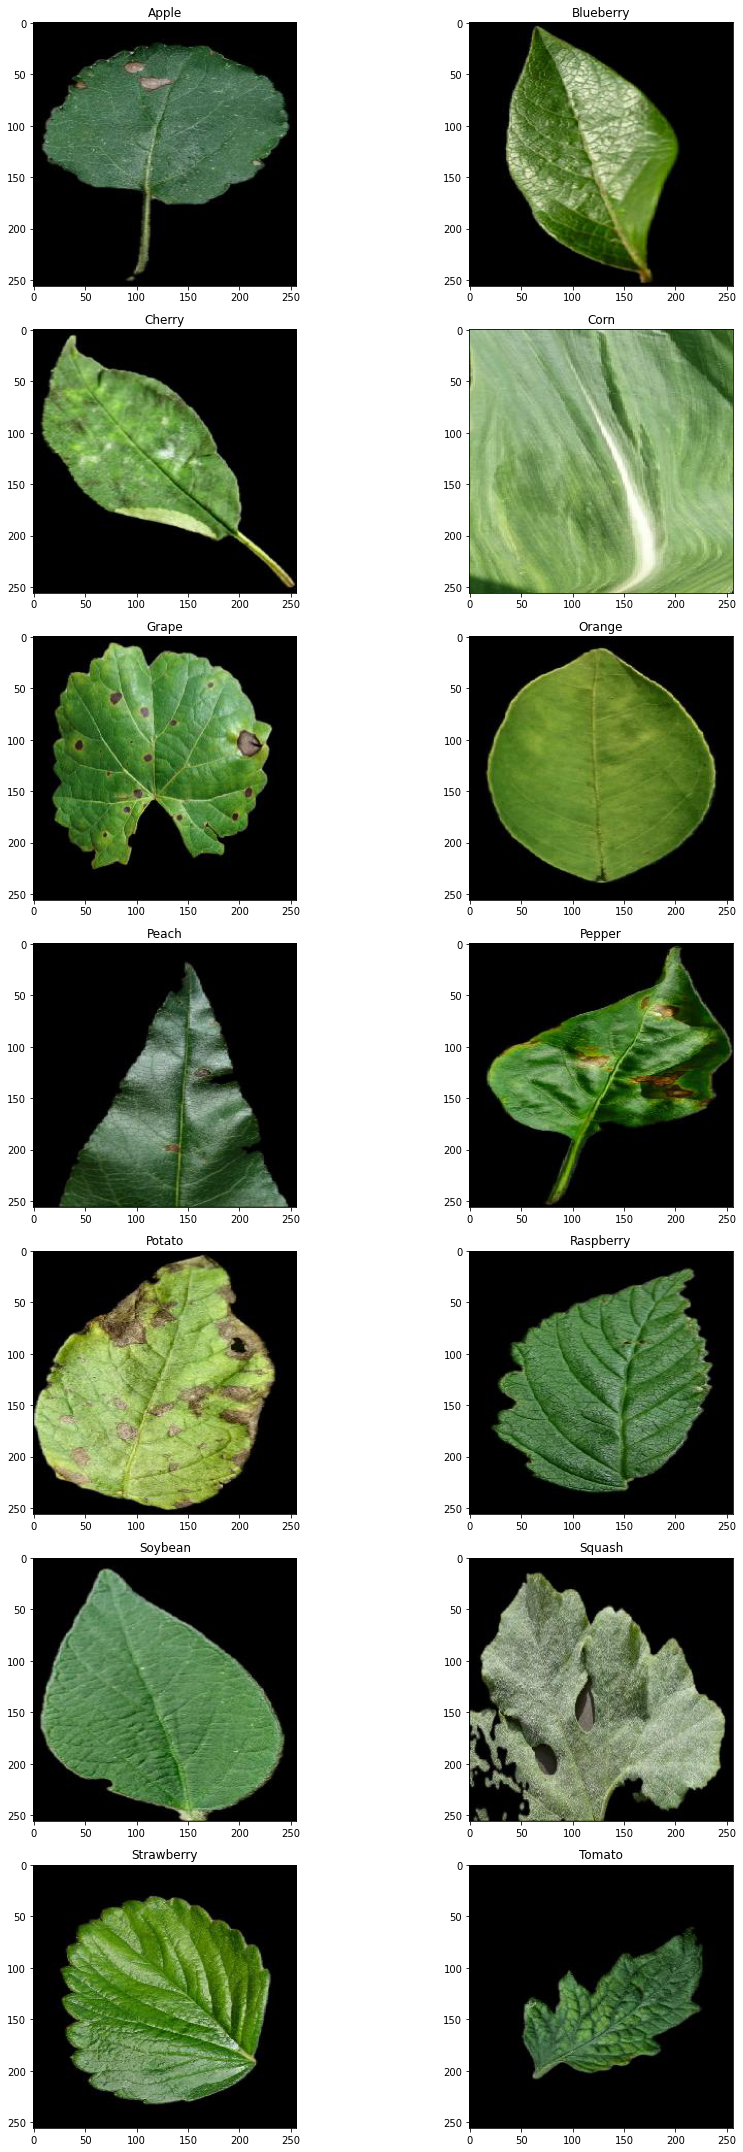

In [4]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

###Data Loader

In [5]:
batch_size = 256

# While creating the data generator, split in train and test sets

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training


train_datagen = ImageDataGenerator(
    rotation_range=30,
    height_shift_range=50,
    width_shift_range=50,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    vertical_flip=True,
    validation_split=0.1)


train_generator = train_datagen.flow_from_directory(directory= training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed,
                                               subset='training'
                                               )

valid_generator = train_datagen.flow_from_directory(directory= training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed,
                                               subset='validation'
                                               )


Found 15963 images belonging to 14 classes.
Found 1765 images belonging to 14 classes.


In [6]:
# check labels (keep lexicographical order)
print("Assigned labels")
print(train_generator.class_indices)
print()
print("Target classes")
print(train_generator.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


In [7]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (256, 256, 256, 3)
Target shape: (256, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: 13
Class name: Tomato


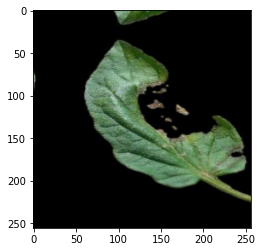

In [8]:
# Get a sample from dataset and show info
_ = get_next_batch(train_generator)

###Models metadata

In [9]:
input_shape = (256, 256, 3)       # image resolution is 256*256 rgb
epochs = 200                      # MESSO 200 PERCHE' NELLE ESE ABBIAMO FATTO COSI', CONTROLLA

###VGG19 model

2021-11-25 10:46:17.418901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 10:46:17.518338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 10:46:17.519046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 10:46:17.520164: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

27033600/27018416 [==============================] - 0s 0us/step
Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
____________________

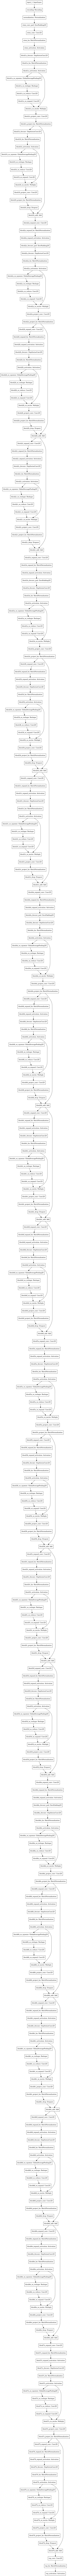

In [10]:
# Download and plot the VGG16 model
supernet = tfk.applications.EfficientNetB1(
    include_top=False,    # we remove the classifier and keep only the feature extraction part
    weights="imagenet",   
    input_shape=(256,256,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
GlobalPooling (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

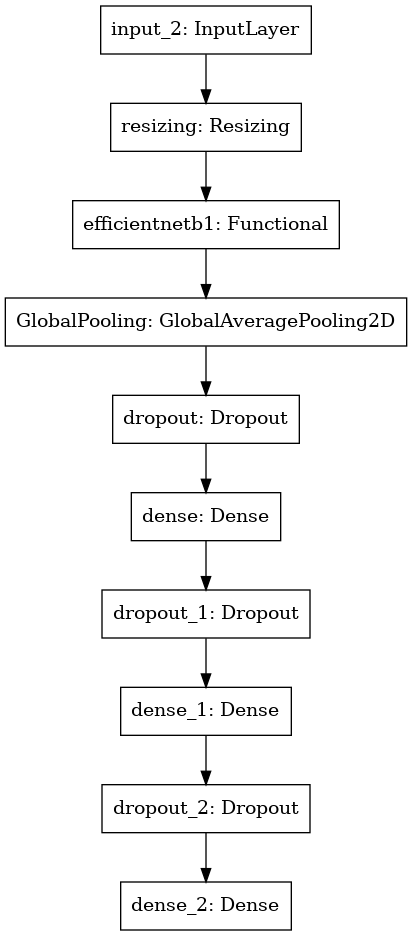

In [11]:
#import regularizers
from tensorflow.keras import regularizers
# Use the supernet as feature extractor
supernet.trainable = False      # the optimizer won't consider the parameters of vgg gduring the optimization

inputs = tfk.Input(shape=(256,256,3))
x = tfkl.Resizing(256, 256, interpolation="bicubic")(inputs)        # why resize? to what dimension?
#x = supernet(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = supernet(x, training=False)

# beginning of the part we are going to train
x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    64, 
    kernel_regularizer=regularizers.l2(0.01),
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    32,
    kernel_regularizer=regularizers.l2(0.01),
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
# end of the part we are going to train - VGG remains fixed

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()
tfk.utils.plot_model(tl_model)

In [12]:
d_class_weights = {
 0: 1.2709710218607015,
 1: 2.9515938606847696,
 2: 2.0644095788604457,
 3: 1.0692899914456802,
 4: 0.8383635144198525,
 5: 0.7114399544678429,
 6: 1.352813852813853,
 7: 1.676727028839705,
 8: 1.8601190476190477,
 9: 4.201680672268908,
 10: 0.7647598654022637,
 11: 2.0644095788604457,
 12: 1.9201228878648233,
 13: 0.22561140691273351}
d_class_weights

{0: 1.2709710218607015,
 1: 2.9515938606847696,
 2: 2.0644095788604457,
 3: 1.0692899914456802,
 4: 0.8383635144198525,
 5: 0.7114399544678429,
 6: 1.352813852813853,
 7: 1.676727028839705,
 8: 1.8601190476190477,
 9: 4.201680672268908,
 10: 0.7647598654022637,
 11: 2.0644095788604457,
 12: 1.9201228878648233,
 13: 0.22561140691273351}

In [13]:
# Train the model
tl_history = tl_model.fit(
    x = train_generator,
    class_weight = d_class_weights,
    batch_size = 256,
    epochs = 200,
    validation_data = valid_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

2021-11-25 10:46:31.016265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-25 10:46:42.887238: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 328s 5s/step - loss: 3.1581 - accuracy: 0.3624 - val_loss: 2.0587 - val_accuracy: 0.6918
Epoch 2/200
63/63 [==============================] - 290s 5s/step - loss: 1.8518 - accuracy: 0.6224 - val_loss: 1.5817 - val_accuracy: 0.7360
Epoch 3/200
63/63 [==============================] - 283s 4s/step - loss: 1.4449 - accuracy: 0.7202 - val_loss: 1.3280 - val_accuracy: 0.7813
Epoch 4/200
63/63 [==============================] - 284s 5s/step - loss: 1.2632 - accuracy: 0.7589 - val_loss: 1.2844 - val_accuracy: 0.7853
Epoch 5/200
63/63 [==============================] - 285s 5s/step - loss: 1.1734 - accuracy: 0.7781 - val_loss: 1.2448 - val_accuracy: 0.7875
Epoch 6/200
63/63 [==============================] - 283s 4s/step - loss: 1.0987 - accuracy: 0.7896 - val_loss: 1.2611 - val_accuracy: 0.7751
Epoch 7/200
63/63 [==============================] - 284s 5s/step - loss: 1.0404 - accuracy: 0.8040 - val_loss: 1.1793 - val_accuracy: 0.7858
Epoch 8/200
63/63 

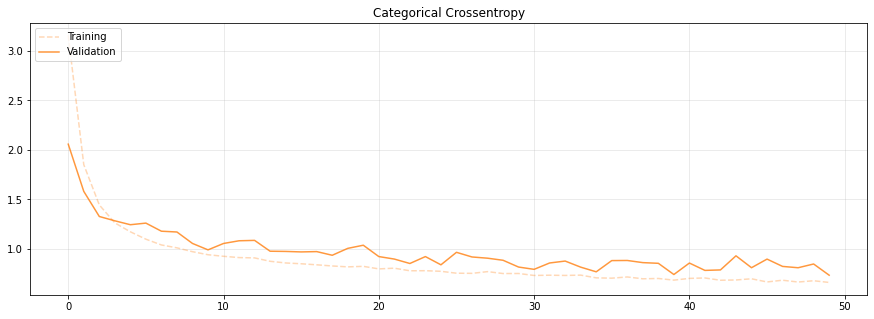

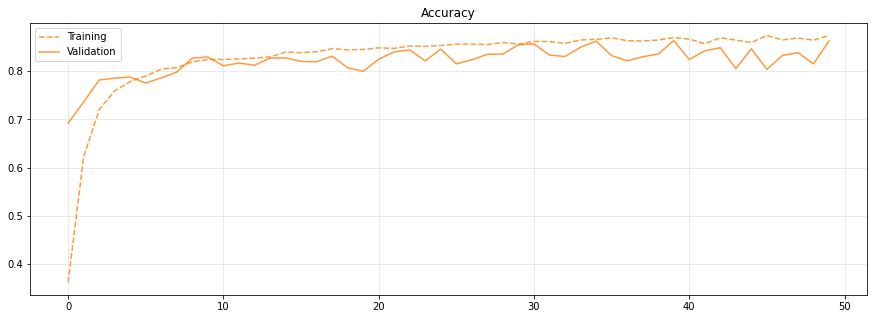

In [14]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [15]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model  # To avoid filling the memory

2021-11-25 15:03:49.232680: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
GlobalPooling (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

In [17]:

# Set all VGG layers to True
ft_model.get_layer('efficientnetb1').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetb1').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block1b_dwconv True
18 block1b_bn True
19 block1b_activation True
20 block1b_se_squeeze True
21 block1b_se_reshape True
22 block1b_se_reduce True
23 block1b_se_expand True
24 block1b_se_excite True
25 block1b_project_conv True
26 block1b_project_bn True
27 block1b_drop True
28 block1b_add True
29 block2a_expand_conv True
30 block2a_expand_bn True
31 block2a_expand_activation True
32 block2a_dwconv_pad True
33 block2a_dwconv True
34 block2a_bn True
35 block2a_activation True
36 block2a_se_squeeze True
37 block2a_se_reshape True
38 block2a_se_reduce True
39 block2a_se_expand True
40 block2a_se_excite True
41 

In [18]:

# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('efficientnetb1').layers[:280]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetb1').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

# this way we set true also the pooling but it's not a problem since it doesn't have parameters



0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_se_ex

In [19]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [20]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = train_generator,
    class_weight = d_class_weights,
    batch_size = 256,
    epochs = 50,
    validation_data = valid_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/50
63/63 [==============================] - 306s 5s/step - loss: 0.5593 - accuracy: 0.8973 - val_loss: 0.6833 - val_accuracy: 0.8799
Epoch 2/50
63/63 [==============================] - 292s 5s/step - loss: 0.4533 - accuracy: 0.9349 - val_loss: 0.6472 - val_accuracy: 0.8873
Epoch 3/50
63/63 [==============================] - 289s 5s/step - loss: 0.3914 - accuracy: 0.9495 - val_loss: 0.4910 - val_accuracy: 0.9337
Epoch 4/50
63/63 [==============================] - 289s 5s/step - loss: 0.3532 - accuracy: 0.9615 - val_loss: 0.5069 - val_accuracy: 0.9252
Epoch 5/50
63/63 [==============================] - 289s 5s/step - loss: 0.3235 - accuracy: 0.9674 - val_loss: 0.4494 - val_accuracy: 0.9388
Epoch 6/50
63/63 [==============================] - 290s 5s/step - loss: 0.3092 - accuracy: 0.9698 - val_loss: 0.3878 - val_accuracy: 0.9518
Epoch 7/50
63/63 [==============================] - 288s 5s/step - loss: 0.2767 - accuracy: 0.9761 - val_loss: 0.3717 - val_accuracy: 0.9552
Epoch 8/50
63

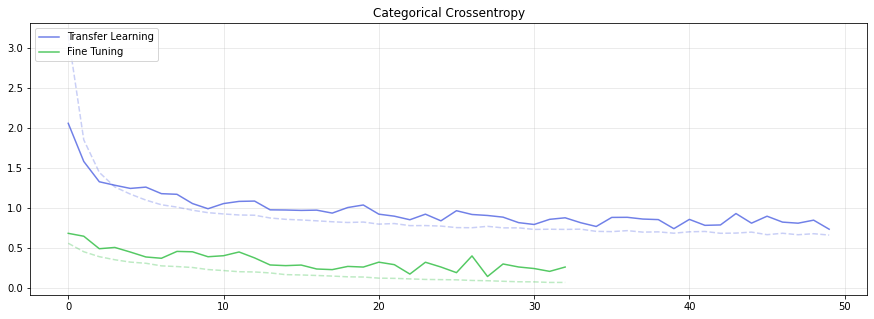

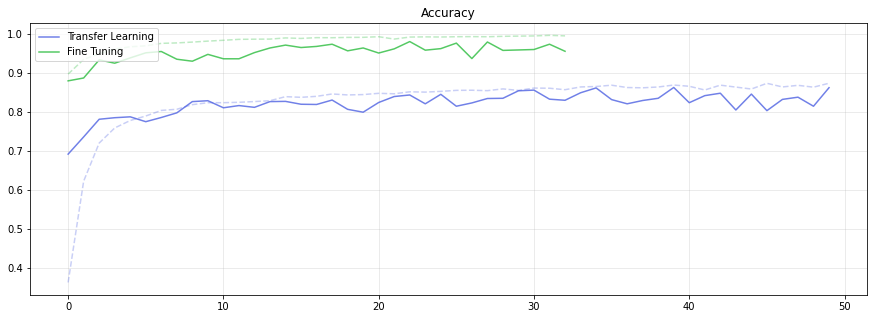

In [21]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [22]:
ft_model.save('FineTuningModel')
del ft_model

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
